In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

It turns out, just computing the standard deviation for small batch sizes is biased.

In [5]:
batchSize = 2
iters = 100000
avgStd = 0.0
for i in range(iters):
    avgStd += torch.std(torch.normal(0, 1, [batchSize]))
avgStd /= iters
print(avgStd)

tensor(0.7987)


Note that increasing iters will not fix this problem, the output will just vary less. But it'll still be below 1.0.

Why is this? https://en.wikipedia.org/wiki/Bessel%27s_correction#Source_of_bias has a good explanation, the jist is that your emperical mean is likely to be closer to your data points than the actual mean. This means that when you subtract it from each data point to compute standard deviation, those differences are likely to be smaller than they should be if you were using the true mean.

Supposedly the fix for this is to divide by (n-1) instead of dividing by n, and pytorch actually does that internally. There's a "unbiased" paramater that is default true. If you set this to false, it'll divide by n, and you can see that makes the problem worse:

In [6]:
batchSize = 2
iters = 100000
avgStd = 0.0
for i in range(iters):
    avgStd += torch.std(torch.normal(0, 1, [batchSize]), unbiased=False)
avgStd /= iters
print(avgStd)

tensor(0.5640)


Still, dividing by n-1 instead of n (this is called Bessel's correction) doesn't completely fix the issue, it just helps. We could just emperically compute the difference, and then just store those corrections and use them. Lets run some experiments to plot how far off it is for various batch sizes:

In [26]:
def sampleKTimes(k, f):
    avg = torch.zeros([1])
    for i in range(k):
        avg += f()
    return (avg/float(k)).data.numpy()

def runVarianceExperiment(fixupIters, maxBatchSize, dataFunc, returnResults=False):
    batchSizes = []
    biased = []
    unbiased = []
    for b in range(2, maxBatchSize):
        batchSizes.append(b)
        biased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b), unbiased=False)))
        unbiased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b), unbiased=True)))

    if not returnResults:
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(211)
        ax1.plot(batchSizes,biased, label="Biased " + str(fixupIters) + " iters")
        ax1.plot(batchSizes,unbiased, label="Unbiased " + str(fixupIters) + " iters")
        ax1.set_ylabel('Estimated Standard Deviation')
        ax1.set_xlabel('Batch Size')
        ax1.legend()
    else: return batchSizes, biased, unbiased
    

In [38]:
dataFunc = lambda batchSize: torch.normal(0, 1, [batchSize])

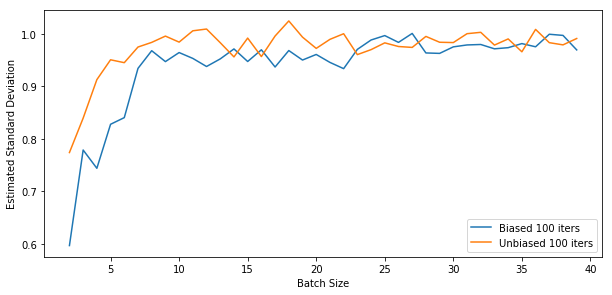

In [28]:
runVarianceExperiment(fixupIters=100, maxBatchSize=40, dataFunc=dataFunc)

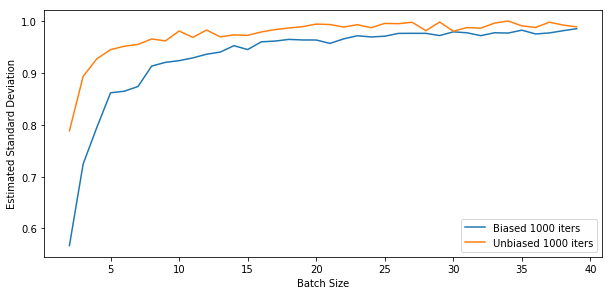

In [29]:
runVarianceExperiment(fixupIters=1000, maxBatchSize=40, dataFunc=dataFunc)

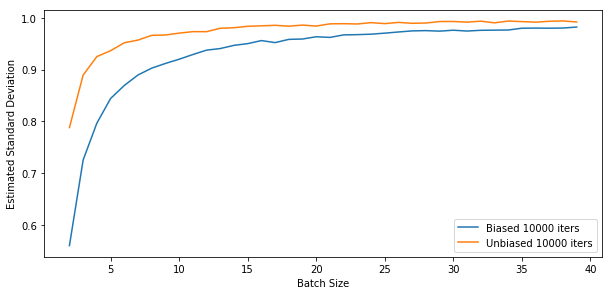

In [30]:
runVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=dataFunc)

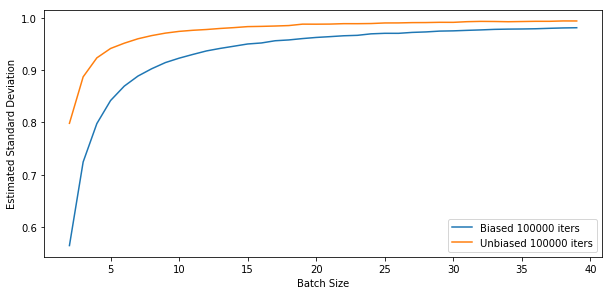

In [31]:
runVarianceExperiment(fixupIters=100000, maxBatchSize=40, dataFunc=dataFunc)

You can see that as we add more iters, the outputs vary less, but they don't converge at 1.0 even though that it is the true standard deviation of our data.

Lets compute the correction factors:

In [33]:
batchSizes, biased, unbiased = runVarianceExperiment(fixupIters=100000, maxBatchSize=40, dataFunc=dataFunc, returnResults=True)

In [40]:
correctionFactorsBiased = 1.0/np.array(biased)
correctionFactorsUnbiased = 1.0/np.array(unbiased)

def getCorrectionBiased(batchSize):
    index = batchSize-2
    if index >= len(correctionFactorsBiased): return 1.0 # eventually with high enough batch size we don't need a correction
    else: return correctionFactorsBiased[index]

def getCorrectionUnbiased(batchSize):
    index = batchSize-2
    if index >= len(correctionFactorsUnbiased): return 1.0 # eventually with high enough batch size we don't need a correction
    else: return correctionFactorsUnbiased[index]

Now lets try some experiements using the correction factors:

In [41]:
def runFixedVarianceExperiment(fixupIters, maxBatchSize, dataFunc, returnResults=False):
    batchSizes = []
    biased = []
    unbiased = []
    for b in range(2, maxBatchSize):
        batchSizes.append(b)
        biased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b)*getCorrectionBiased(b), unbiased=False)))
        unbiased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b)*getCorrectionUnbiased(b), unbiased=True)))

    if not returnResults:
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(211)
        ax1.plot(batchSizes,biased, label="Biased " + str(fixupIters) + " iters")
        ax1.plot(batchSizes,unbiased, label="Unbiased " + str(fixupIters) + " iters")
        ax1.set_ylabel('Estimated Standard Deviation')
        ax1.set_xlabel('Batch Size')
        ax1.legend()
    else: return batchSizes, biased, unbiased

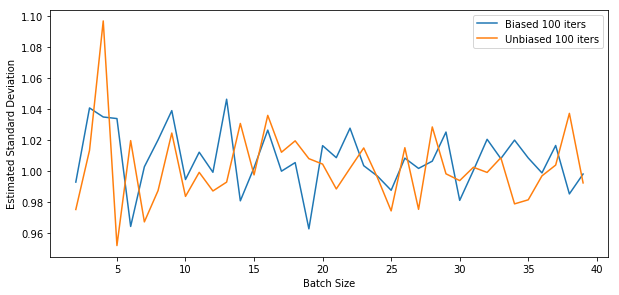

In [42]:
runFixedVarianceExperiment(fixupIters=100, maxBatchSize=40, dataFunc=dataFunc)

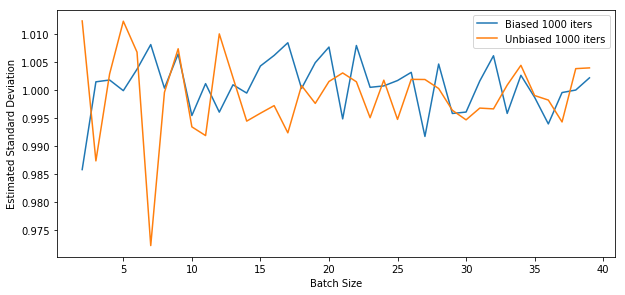

In [43]:
runFixedVarianceExperiment(fixupIters=1000, maxBatchSize=40, dataFunc=dataFunc)

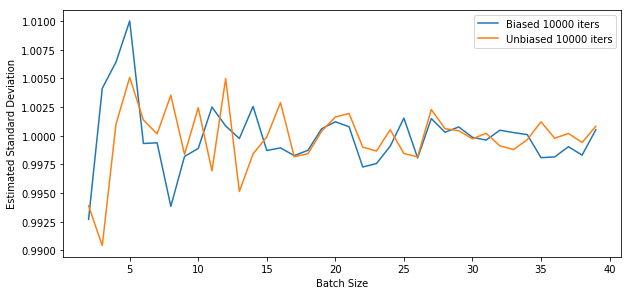

In [44]:
runFixedVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=dataFunc)

Much better! (look at the y axis, it's always very close to 1.0, even for small batch sizes) However, it's worth checking: what happens when our variance is not 1.0? What if our mean is different? Does this still work?

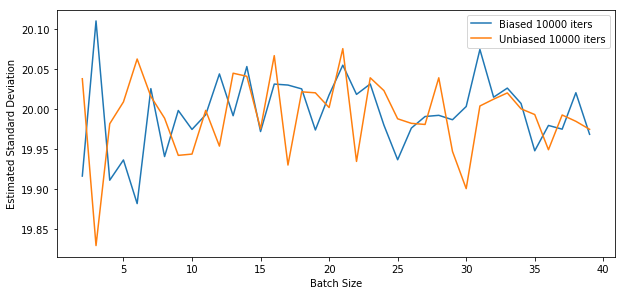

In [47]:
runFixedVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=lambda batchSize: torch.normal(0, 20, [batchSize]))

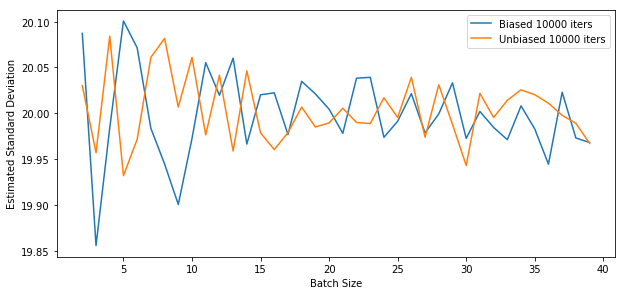

In [46]:
runFixedVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=lambda batchSize: torch.normal(-20, 20, [batchSize]))

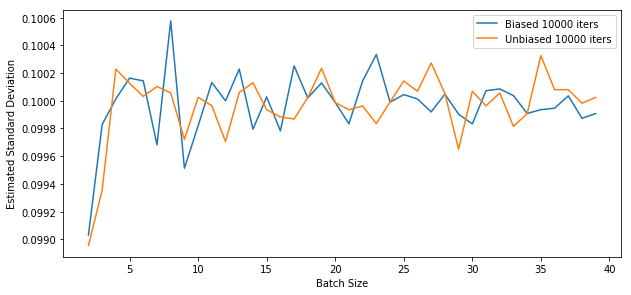

In [48]:
runFixedVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=lambda batchSize: torch.normal(10, 0.1, [batchSize]))

Yup seems to work! A proof of why this works is in progress. In the meantime, just for completeness, lets compare the fixed version to the original:

In [53]:
def runComparisonVarianceExperiment(fixupIters, maxBatchSize, dataFunc, returnResults=False):
    batchSizes = []
    biased = []
    unbiased = []
    biasedFixed = []
    unbiasedFixed = []
    for b in range(2, maxBatchSize):
        batchSizes.append(b)
        biased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b), unbiased=False)))
        unbiased.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b), unbiased=True)))
        biasedFixed.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b)*getCorrectionBiased(b), unbiased=False)))
        unbiasedFixed.append(sampleKTimes(fixupIters, lambda: torch.std(dataFunc(b)*getCorrectionUnbiased(b), unbiased=True)))

    if not returnResults:
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(211)
        ax1.plot(batchSizes,biased, label="Biased " + str(fixupIters) + " iters")
        ax1.plot(batchSizes,unbiased, label="Unbiased " + str(fixupIters) + " iters")
        ax1.plot(batchSizes,biasedFixed, label="Biased fixed " + str(fixupIters) + " iters")
        ax1.plot(batchSizes,unbiasedFixed, label="Unbiased fixed " + str(fixupIters) + " iters")
        ax1.set_ylabel('Estimated Standard Deviation')
        ax1.set_xlabel('Batch Size')
        ax1.legend()
    else: return batchSizes, biased, unbiased, biasedFixed, unbiasedFixed

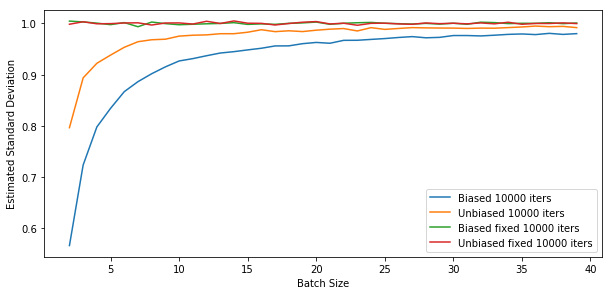

In [54]:
runComparisonVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=dataFunc)

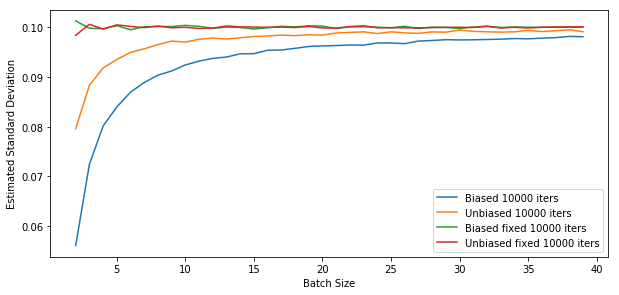

In [56]:
runComparisonVarianceExperiment(fixupIters=10000, maxBatchSize=40, dataFunc=lambda batchSize: torch.normal(10, 0.1, [batchSize]))